In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
import graphviz
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Gradient Boosted Trees

In [2]:
df = pd.read_csv('./Wine_red.csv',sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df_test = df.sample(frac=0.2,replace=False,random_state=0).copy()
df_train = df.drop(df_test.index).copy()

features_train = df_train.drop('quality',axis=1)
features_test = df_test.drop('quality',axis=1)

target_train = df_train.quality
target_test = df_test.quality

In [4]:
gbt = GradientBoostingRegressor(max_depth=2,n_estimators=3,learning_rate=1.0)
gbt.fit(features_train,target_train)
for target_train_predict in gbt.staged_predict(features_train):
    R2_train = r2_score(target_train,target_train_predict)
    print('train R2 = ',R2_train.round(3))

train R2 =  0.271
train R2 =  0.343
train R2 =  0.372


In [5]:
gbt = GradientBoostingRegressor(max_depth=2,n_estimators=3,learning_rate=1.0)
gbt.fit(features_train,target_train)
for target_test_predict in gbt.staged_predict(features_test):
    R2_train = r2_score(target_test,target_test_predict)
    print('test R2 = ',R2_train.round(3))

test R2 =  0.204
test R2 =  0.235
test R2 =  0.249


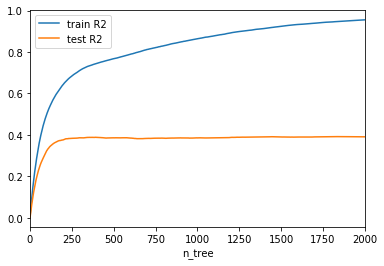

In [6]:
n_trees = 2000
depth = 5

gbt = GradientBoostingRegressor(max_depth=depth,n_estimators=n_trees,learning_rate=0.01)
gbt.fit(features_train,target_train)

n_tree = []
R2_train = []
R2_test = []

target_train_predict = iter(gbt.staged_predict(features_train))
target_test_predict = iter(gbt.staged_predict(features_test))

for k in range(n_trees):
    n_tree.append(k+1)
    R2_train.append(r2_score(target_train,next(target_train_predict)))
    R2_test.append(r2_score(target_test,next(target_test_predict)))
    
performance = pd.DataFrame()
performance['n_tree'] = n_tree
performance['train R2'] = R2_train
performance['test R2'] = R2_test

ax1 = performance.plot.line(x='n_tree',y='train R2')
performance.plot.line(x='n_tree',y='test R2',ax=ax1)

# Bagging

In [7]:
df = pd.read_csv("./tips.csv")
df['size'] = df['size'].astype('float')

In [8]:
df = pd.get_dummies(df)
df.head(3)

,total_bill,tip,size,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch
0,16.99,1.01,2.0,1,0,1,0,0,0,1,0,1,0
1,10.34,1.66,3.0,0,1,1,0,0,0,1,0,1,0
2,21.01,3.50,3.0,0,1,1,0,0,0,1,0,1,0


In [9]:
df_test = df.sample(frac=0.2,replace=False,random_state=0).copy()
df_train = df.drop(df_test.index).copy()

In [10]:
features_train = df_train.drop('tip',axis=1)
features_test = df_test.drop('tip',axis=1)

In [11]:
target_train = df_train.tip
target_test = df_test.tip

In [12]:
grid = {'max_depth': np.arange(1,26)}

rtree = DecisionTreeRegressor()
rtreeCV = GridSearchCV(rtree,param_grid=grid,return_train_score=True)
rtreeCV.fit(features_train,target_train)

print()
print('optimal depth= ', rtreeCV.best_params_, 'validation R2= ', rtreeCV.best_score_.round(3))


optimal depth=  {'max_depth': 2} validation R2=  0.265


In [13]:
rtree_optimal = rtreeCV.best_estimator_
target_predicted = rtree_optimal.predict(features_test)
MSE_test = np.sqrt(mean_squared_error(target_test,target_predicted))
print('test MSE: ', MSE_test.round(3))

test MSE:  0.749


In [14]:
rtree = DecisionTreeRegressor(max_depth=2)
rtree.fit(features_train,target_train)
target_predicted = rtree_optimal.predict(features_test)
MSE_test = np.sqrt(mean_squared_error(target_test,target_predicted))
print('test MSE: ', MSE_test.round(3))

test MSE:  0.749


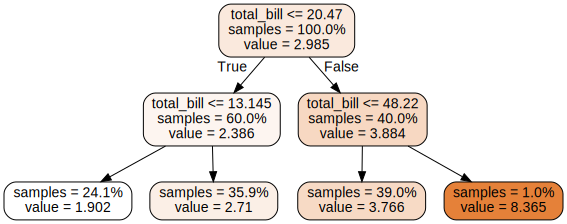

In [15]:
dot_data = export_graphviz(rtree,
                          out_file=None,
                          feature_names=features_test.columns,
                          proportion=True,
                          impurity=False,
                          filled=True,
                          rounded=True,
                          )
graph = graphviz.Source(dot_data)
graph

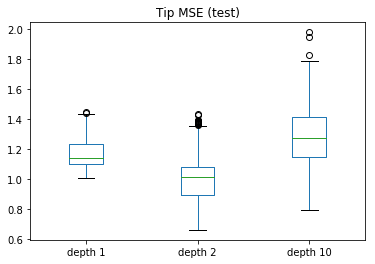

In [16]:
N = 1000
depth = [1,2,10]
errors = pd.DataFrame(index=range(1000),columns=['depth 1', 'depth 2', 'depth 10'])

for i in range(N):
    df_train_bootstrapped= df_train.sample(frac=1,replace=True).copy()
    features_bootstrapped = df_train_bootstrapped.drop('tip',axis=1)
    target_bootstrapped = df_train_bootstrapped.tip
    for j in range(3):
        rtree = DecisionTreeRegressor(max_depth=depth[j])
        rtree.fit(features_bootstrapped, target_bootstrapped)
        target_predicted = rtree.predict(features_test)
        errors.iloc[i, j] = np.sqrt(mean_squared_error(target_test,target_predicted))
        
errors.plot.box(title='Tip MSE (test)')

In [17]:
rtree = DecisionTreeRegressor(max_depth=10)

n_records = target_test.shape[0]
n_trees = 1000
target_forest = pd.DataFrame(index=range(n_records),columns=range(n_trees))

for k in range(n_trees):
    df_train_bootstrapped = df_train.sample(frac=1.0,replace=True).copy()
    features_bootstrapped = df_train_bootstrapped.drop('tip',axis=1)
    target_bootstrapped = df_train_bootstrapped.tip
    rtree.fit(features_bootstrapped, target_bootstrapped)
    target_forest.iloc[:,k] = rtree.predict(features_test)
    
target_predicted = target_forest.mean(axis=1)

RMSE_test = np.sqrt(mean_squared_error(target_test,target_predicted))
print('test MSE = ', RMSE_test.round(3))

test MSE =  0.883


In [18]:
rtree = DecisionTreeRegressor(max_depth=10)
bag = BaggingRegressor(rtree,n_estimators=1000,n_jobs=-1)
bag.fit(features_train,target_train)
target_predict = bag.predict(features_test)

RMSE_test = np.sqrt(mean_squared_error(target_test,target_predicted))
print('test MSE=', RMSE_test.round(3))

test MSE= 0.883


# Random Forests

In [19]:
df = pd.read_csv("./tips.csv")
df['size'] = df['size'].astype('float')

In [20]:
df = pd.get_dummies(df)
df.head(3)

,total_bill,tip,size,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch
0,16.99,1.01,2.0,1,0,1,0,0,0,1,0,1,0
1,10.34,1.66,3.0,0,1,1,0,0,0,1,0,1,0
2,21.01,3.50,3.0,0,1,1,0,0,0,1,0,1,0


In [21]:
df_test = df.sample(frac=0.2,replace=False,random_state=0).copy()
df_train = df.drop(df_test.index).copy()

In [22]:
features_train = df_train.drop('tip',axis=1)
features_test = df_test.drop('tip',axis=1)

In [23]:
target_train = df_train.tip
target_test = df_test.tip

In [24]:
grid = {'max_depth': np.arange(1,26)}

rtree = DecisionTreeRegressor()
rtreeCV = GridSearchCV(rtree,param_grid=grid,return_train_score=True)
rtreeCV.fit(features_train,target_train)

print()
print('optimal depth= ', rtreeCV.best_params_, 'validation R2= ', rtreeCV.best_score_.round(3))


optimal depth=  {'max_depth': 2} validation R2=  0.265


In [25]:
rtree_optimal = rtreeCV.best_estimator_
target_predicted = rtree_optimal.predict(features_test)
MSE_test = np.sqrt(mean_squared_error(target_test,target_predicted))
print('test MSE: ', MSE_test.round(3))

test MSE:  0.749


In [26]:
rtree = DecisionTreeRegressor(max_depth=2)
rtree.fit(features_train,target_train)
target_predicted = rtree_optimal.predict(features_test)
MSE_test = np.sqrt(mean_squared_error(target_test,target_predicted))
print('test MSE: ', MSE_test.round(3))

test MSE:  0.749


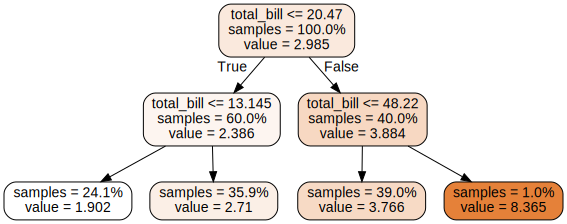

In [27]:
dot_data = export_graphviz(rtree,
                          out_file=None,
                          feature_names=features_test.columns,
                          proportion=True,
                          impurity=False,
                          filled=True,
                          rounded=True,
                          )
graph = graphviz.Source(dot_data)
graph

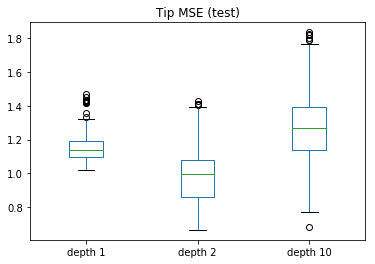

In [28]:
N = 1000
depth = [1,2,10]
errors = pd.DataFrame(index=range(1000),columns=['depth 1', 'depth 2', 'depth 10'])

for i in range(N):
    df_train_bootstrapped= df_train.sample(frac=1,replace=True).copy()
    features_bootstrapped = df_train_bootstrapped.drop('tip',axis=1)
    target_bootstrapped = df_train_bootstrapped.tip
    for j in range(3):
        rtree = DecisionTreeRegressor(max_depth=depth[j])
        rtree.fit(features_bootstrapped, target_bootstrapped)
        target_predicted = rtree.predict(features_test)
        errors.iloc[i, j] = np.sqrt(mean_squared_error(target_test,target_predicted))
        
errors.plot.box(title='Tip MSE (test)')

In [29]:
rtree = DecisionTreeRegressor(max_depth=10)

n_records = target_test.shape[0]
n_trees = 1000
target_forest = pd.DataFrame(index=range(n_records),columns=range(n_trees))

for k in range(n_trees):
    df_train_bootstrapped = df_train.sample(frac=1.0,replace=True).copy()
    features_bootstrapped = df_train_bootstrapped.drop('tip',axis=1)
    target_bootstrapped = df_train_bootstrapped.tip
    rtree.fit(features_bootstrapped, target_bootstrapped)
    target_forest.iloc[:,k] = rtree.predict(features_test)
    
target_predicted = target_forest.mean(axis=1)

RMSE_test = np.sqrt(mean_squared_error(target_test,target_predicted))
print('test MSE = ', RMSE_test.round(3))

test MSE =  0.889


In [30]:
rtree = DecisionTreeRegressor(max_depth=10)
bag = BaggingRegressor(rtree,n_estimators=1000,n_jobs=-1)
bag.fit(features_train,target_train)
target_predict = bag.predict(features_test)

RMSE_test = np.sqrt(mean_squared_error(target_test,target_predicted))
print('test MSE=', RMSE_test.round(3))

test MSE= 0.889


# SVM Regression

In [31]:
df = pd.read_csv("./tips.csv")
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [32]:
target = df.tip
features = df.drop('tip',axis=1)
features = pd.get_dummies(df)
features = (features - features.mean()) / features.std()
features.head()

,total_bill,tip,size,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch
0,-0.314066,-1.436993,-0.598961,1.340598,-1.340598,0.783179,-0.783179,-0.289997,-0.742879,1.483734,-0.582463,0.620307,-0.620307
1,-1.061054,-0.967217,0.452453,-0.742879,0.742879,0.783179,-0.783179,-0.289997,-0.742879,1.483734,-0.582463,0.620307,-0.620307
2,0.137497,0.362610,0.452453,-0.742879,0.742879,0.783179,-0.783179,-0.289997,-0.742879,1.483734,-0.582463,0.620307,-0.620307
3,0.437416,0.225291,-0.598961,-0.742879,0.742879,0.783179,-0.783179,-0.289997,-0.742879,1.483734,-0.582463,0.620307,-0.620307
4,0.539635,0.442111,1.503867,1.340598,-1.340598,0.783179,-0.783179,-0.289997,-0.742879,1.483734,-0.582463,0.620307,-0.620307


In [33]:
grid = {'C': np.linspace(100,400,10)}

clf = SVR()
clfCV = GridSearchCV(clf,param_grid=grid,return_train_score=True,n_jobs=-1)
clfCV.fit(features,target)

print()
print('parameters = ', clfCV.best_params_, 'validation R2 = ', clfCV.best_score_.round(3))


parameters =  {'C': 100.0} validation R2 =  0.896


C:\Users\rileyma\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [34]:
target = df.tip
features = df.drop('tip',axis=1)
features = pd.get_dummies(df)
features = (features - features.mean()) / features.std()
features.head()

,total_bill,tip,size,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch
0,-0.314066,-1.436993,-0.598961,1.340598,-1.340598,0.783179,-0.783179,-0.289997,-0.742879,1.483734,-0.582463,0.620307,-0.620307
1,-1.061054,-0.967217,0.452453,-0.742879,0.742879,0.783179,-0.783179,-0.289997,-0.742879,1.483734,-0.582463,0.620307,-0.620307
2,0.137497,0.362610,0.452453,-0.742879,0.742879,0.783179,-0.783179,-0.289997,-0.742879,1.483734,-0.582463,0.620307,-0.620307
3,0.437416,0.225291,-0.598961,-0.742879,0.742879,0.783179,-0.783179,-0.289997,-0.742879,1.483734,-0.582463,0.620307,-0.620307
4,0.539635,0.442111,1.503867,1.340598,-1.340598,0.783179,-0.783179,-0.289997,-0.742879,1.483734,-0.582463,0.620307,-0.620307


In [35]:
grid = {'C': [0.01,0.1,1,10,100,1000,10000]}

clf = SVR()
clfCV = GridSearchCV(clf,param_grid=grid,return_train_score=True,n_jobs=-1)
clfCV.fit(features,target)

print()
print('parameters = ', clfCV.best_params_, 'validation R2 = ', clfCV.best_score_.round(3))
print('training R2 = ', clfCV.best_estimator_.score(features,target).round(3))


parameters =  {'C': 10} validation R2 =  0.896
training R2 =  0.997


C:\Users\rileyma\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# PCA isn't a classifier, just a tool for analysis

- Look at PCA Auto Lesson (Lesson 23)